In [119]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, pi, atan, atan2, fabs

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelsize'] = 12

In [2]:
propiedades = pd.read_csv('properati.csv')
#propiedades = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/properati.csv')

In [3]:
#Ya no es necesario 

#Elimino columnas innecesarias
#propiedades.drop(['Unnamed: 0'], axis = 1, inplace = True)
propiedades.head(2)


,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado
0,2012-08-08,NaN,NaN,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,...,NaN,apartment,3.0,Capital Federal,102.0,2013,7,2012,8,11
1,2012-08-08,NaN,NaN,2013-07-01,11.0,-34.546730,-58.550579,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,...,NaN,apartment,3.0,Bs.As. G.B.A. Zona Norte,73.0,2013,7,2012,8,11


In [4]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 23 columns):
created_on                    object
currency                      object
expenses                      float64
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
superficie                    float64
Year                          int64
Month                         int64
Year_created                  int64
Month_created                 int64
cantidad_meses_publicado      int64
dtypes: float64(11), int64(5),

In [5]:
#ya no es necesario

#Elimino los registros que no sean de Capital Federal o Gran Buenos Aires
#capital = propiedades ['state_name'] == 'Capital Federal'
#gba = propiedades ['state_name'].str.contains('Bs.As. G.B.A.')
#propiedades = propiedades [capital | gba].reset_index()
#propiedades.drop("index", axis = 1, inplace = True)
#propiedades.info()


In [3]:
#Compruebo que solo haya capital y gba
propiedades.groupby('state_name').agg(np.size)['floor']

state_name
Bs.As. G.B.A. Zona Norte    820412.0
Bs.As. G.B.A. Zona Oeste    466592.0
Bs.As. G.B.A. Zona Sur      238355.0
Capital Federal             929950.0
Name: floor, dtype: float64

In [7]:
#Reemplazo todos los tipos de Palermo por uno unico
#propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'] = 'Palermo'
propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'].value_counts()

#ya no es necesario

Palermo    101725
Name: place_name, dtype: int64

In [4]:
#Reemplazo todos los tipos de Lanus por uno unico
#propiedades.loc[(propiedades.place_name.str.contains("Lanus", na = False)) | (propiedades.place_name.str.contains("Lanús", na = False)),'place_name'] = 'Lanús'
propiedades.loc[propiedades.place_name.str.contains("Lanús", na = False),'place_name'].value_counts()

#ya no es necesario

Lanús    29676
Name: place_name, dtype: int64

In [8]:
def unificar_superficie(fila):
    s3,s2,s1 = fila
    if (s3 and not np.isnan(s3)):
        return s3
    if (s2 and not np.isnan(s2)):
        return s2
    if (s1 and not np.isnan(s1)):
        return s1
    return np.nan


#ya no es necesario

In [9]:
#Unifico las superficies
#propiedades.loc[:,'superficie'] = propiedades.loc[:,['surface_covered_in_m2','surface_in_m2','surface_total_in_m2']].apply(unificar_superficie, axis = 1)
#propiedades.drop(['surface_covered_in_m2','surface_in_m2','surface_total_in_m2'], axis = 1, inplace = True)
#propiedades.head(2)

In [10]:
def calcularPrecioM2(fila):
    """Recibe una lista con precio total, superficie total, superficie cubierta y precio por metro cuadrado,
    y calcula este ultimo a partir de los anteriores, cuando es posible"""
    precio_total,superficie_total,superficie_cubierta,precio_m2 = fila
    if (np.isnan(precio_m2)):
        if (superficie_total and not np.isnan(superficie_total)):
            return precio_total/superficie_total
        if(superficie_cubierta and not np.isnan(superficie_cubierta)):
            return precio_total/superficie_cubierta
    return precio_m2

#Ya no es necesario

In [11]:
#Calculo el precio por metro cuadrado a partir del precio total y la superficie
#propiedades.loc[:,'price_usd_per_m2'] = propiedades.loc[:,['price_aprox_usd','price_usd_per_m2', 'superficie']].apply(calcularPrecioM2,axis = 1)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 23 columns):
created_on                    object
currency                      object
expenses                      float64
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
superficie                    float64
Year                          int64
Month                         int64
Year_created                  int64
Month_created                 int64
cantidad_meses_publicado      int64
dtypes: float64(11), int64(5),

### Como es el precio por metro cuadrado en cada zona? Cuales son los barrios con mayor promedio?

In [90]:
tiene_precio = propiedades['price_usd_per_m2'].notnull()

In [66]:
precio_por_zona = propiedades[tiene_precio].loc[propiedades.price_usd_per_m2 <= 10000,['state_name','price_usd_per_m2','lat']]
precio_por_zona.loc[:,'state_name'] = precio_por_zona.loc[:,'state_name'].str.lstrip('Bs.As. ')
precio_por_zona = pd.pivot_table(precio_por_zona, values='price_usd_per_m2', columns=['state_name'],index = 'lat')
precio_por_zona.head(2)

state_name,Capital Federal,G.B.A. Zona Norte,G.B.A. Zona Oeste,G.B.A. Zona Sur
lat,,,,
-89.999744,2200.0,NaN,NaN,NaN
-87.953559,NaN,1833.333333,NaN,NaN


(0, 6000)

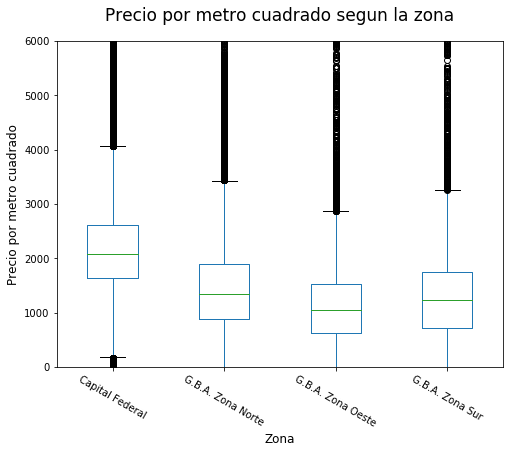

In [120]:
plot = precio_por_zona.plot(kind='box', title = "Precio por metro cuadrado segun la zona", rot = -30);
plot.set_xlabel("Zona")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_ylim([0,6000])

### Para capital federal

In [91]:
precios_capital = propiedades[tiene_precio].loc[(propiedades.state_name == 'Capital Federal') & (propiedades.place_name != 'Capital Federal')\
                                                ,['place_name','price_usd_per_m2']]
precios_capital = precios_capital.groupby('place_name').agg([np.size,np.mean])
precios_capital.describe()

price_usd_per_m2             
                  size         mean
count        62.000000    62.000000
mean       9916.483871  2362.705459
std       13471.621911   848.444749
min           1.000000   946.108213
25%        1540.750000  1910.677812
50%        5537.000000  2212.195475
75%       11857.000000  2505.198477
max       73901.000000  6392.615387

In [92]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_capital = precios_capital[precios_capital[('price_usd_per_m2','size')] > 800]

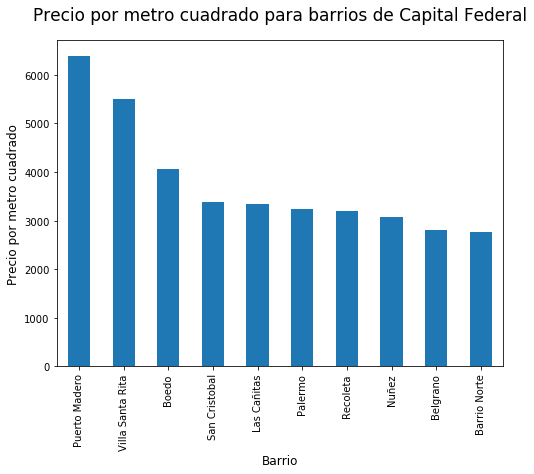

In [121]:
plot = precios_capital[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar');
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de Capital Federal")

### Para gba zona norte

In [94]:
precios_zona_norte = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Norte'),['place_name','price_usd_per_m2']]
precios_zona_norte = precios_zona_norte.groupby('place_name').agg([np.size,np.mean])
precios_zona_norte.describe()

price_usd_per_m2              
                  size          mean
count       340.000000    340.000000
mean       1794.217647   1684.577780
std        7414.215056   1945.461670
min           1.000000     86.700571
25%          17.000000   1007.050859
50%          69.000000   1290.205656
75%         260.250000   1857.814938
max       68810.000000  28194.815849

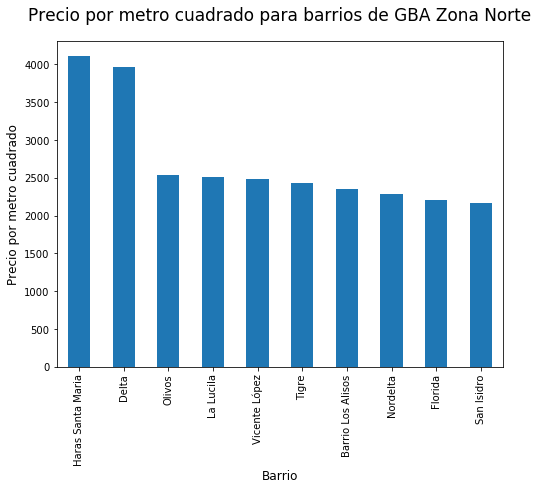

In [122]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_norte = precios_zona_norte[precios_zona_norte[('price_usd_per_m2','size')] > 800]
plot = precios_zona_norte[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar');
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Norte")

### Para gba zona oeste

In [96]:
precios_zona_oeste = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Oeste'),['place_name','price_usd_per_m2']]
precios_zona_oeste = precios_zona_oeste.groupby('place_name').agg([np.size,np.mean])
precios_zona_oeste.describe()

price_usd_per_m2              
                  size          mean
count        88.000000     88.000000
mean       3034.602273   1402.926238
std        7045.519291   1558.779652
min           1.000000     40.870430
25%          66.750000    770.781965
50%         346.000000   1055.920853
75%        2194.750000   1539.934805
max       48490.000000  11598.750000

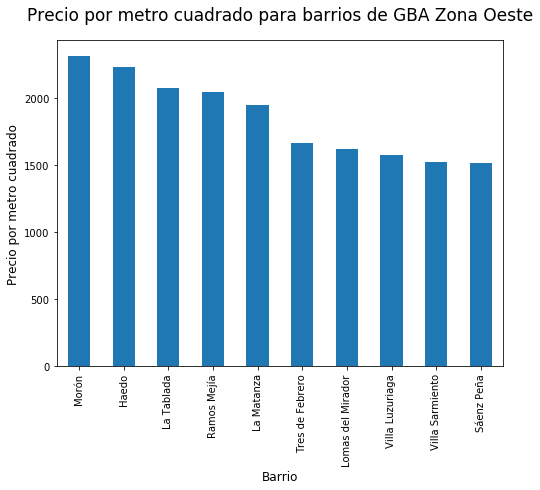

In [123]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_oeste = precios_zona_oeste[precios_zona_oeste[('price_usd_per_m2','size')] > 800]
plot = precios_zona_oeste[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar');
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Oeste")

### Para gba zona sur

In [98]:
precios_zona_sur = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Sur'),['place_name','price_usd_per_m2']]
precios_zona_sur = precios_zona_sur.groupby('place_name').agg([np.size,np.mean])
precios_zona_sur.describe()

price_usd_per_m2               
                  size           mean
count       144.000000     144.000000
mean        906.069444    2342.159877
std        2844.642482    9190.094238
min           1.000000       0.000000
25%          24.000000     643.241429
50%          72.500000    1087.644434
75%         451.250000    1594.669353
max       22160.000000  102857.142857

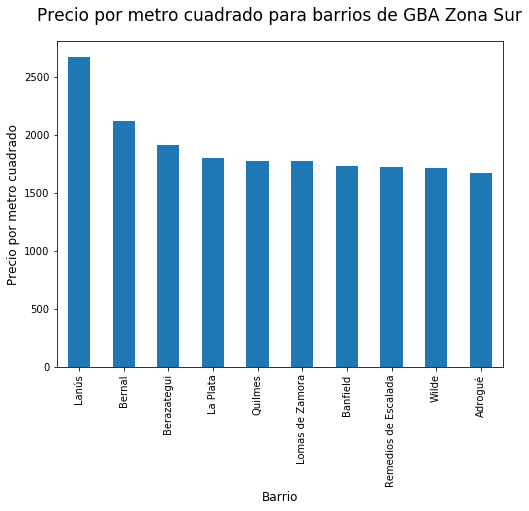

In [124]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_sur = precios_zona_sur[precios_zona_sur[('price_usd_per_m2','size')] > 800]
plot = precios_zona_sur[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar');
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Sur")

### Como evoluciono el precio por metro cuadrado al pasar los anios?

In [7]:
def obtener_anio(fecha):
    return int(fecha.split('-')[0])

In [8]:
def obtener_mes(fecha):
       return int(fecha.split('-')[1])

In [26]:
#propiedades.loc[:,'Year'] = propiedades.loc[:,'fecha_de_publicacion'].apply(obtener_anio)
#propiedades.loc[:,'Month'] = propiedades.loc[:,'fecha_de_publicacion'].apply(obtener_mes)
propiedades.tail(3)

,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado
2455306,2017-07-03,USD,NaN,2017-06-03,NaN,-34.637550,-58.457527,Flores,|Argentina|Capital Federal|Flores|,118000.0,...,2226.415094,apartment,1.0,Capital Federal,46.0,2017,6,2017,7,-1
2455307,2017-07-03,USD,NaN,2017-06-03,NaN,-34.617721,-58.383034,Monserrat,|Argentina|Capital Federal|Monserrat|,81000.0,...,2189.189189,apartment,1.0,Capital Federal,32.0,2017,6,2017,7,-1
2455308,2017-07-03,USD,1500.0,2017-06-03,NaN,-34.628002,-58.433828,Caballito,|Argentina|Capital Federal|Caballito|,87000.0,...,2289.473684,apartment,1.0,Capital Federal,38.0,2017,6,2017,7,-1


In [102]:
precio_por_anio = propiedades[tiene_precio].loc[:,['Year','price_usd_per_m2']].groupby('Year').agg([np.size,np.mean])
precio_por_anio = precio_por_anio.loc[precio_por_anio[('price_usd_per_m2','size')] > 100,:]
precio_por_anio

price_usd_per_m2             
                 size         mean
Year                              
2013         199349.0  2369.190254
2014         345284.0  1890.479226
2015         450676.0  1714.803593
2016         311484.0  2151.086818
2017         381930.0  2735.672688

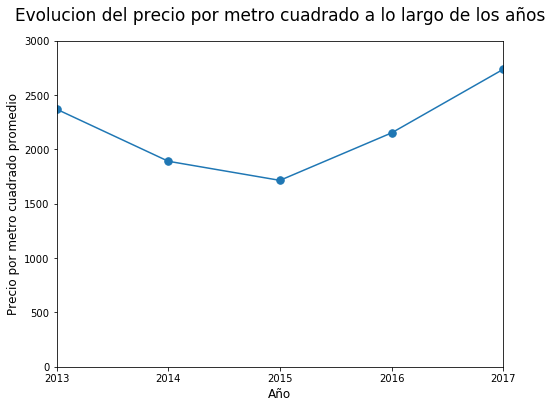

In [129]:
plot = precio_por_anio[('price_usd_per_m2','mean')].plot(marker = '.', markersize = 15);
plot.set_xlabel("Año")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_ylim([0,3000])
plot.set_xticks([2013,2014,2015,2016,2017])
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años")

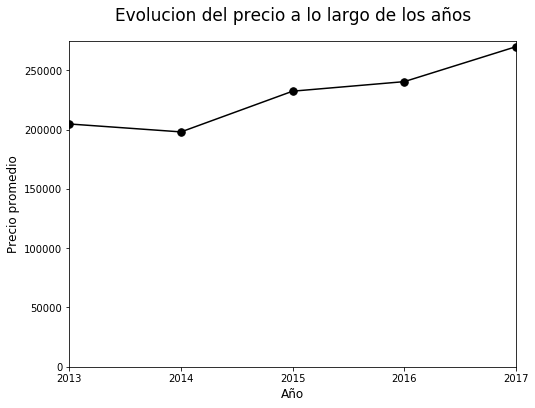

In [133]:
precio_por_anio2 = propiedades.loc[propiedades.price_aprox_usd.notnull(),['Year','price_aprox_usd']].groupby('Year').agg([np.size,np.mean])
precio_por_anio2 = precio_por_anio2.loc[precio_por_anio2[('price_aprox_usd','size')] > 100,:]
plot = precio_por_anio2[('price_aprox_usd','mean')].plot(color='black',marker = '.', markersize = 15);
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio")
plot.set_ylim([0,275000])
plot.set_title("Evolucion del precio a lo largo de los años")
plot.set_xticks([2013,2014,2015,2016,2017])

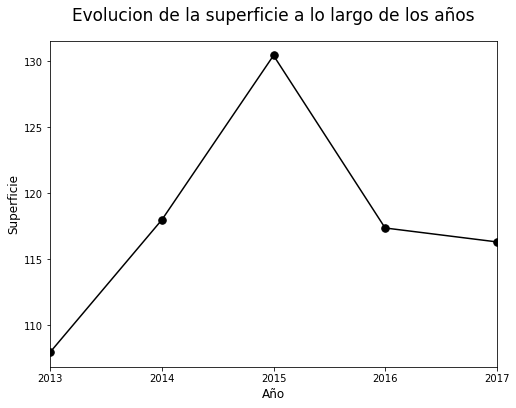

In [160]:
precio_por_anio3 = propiedades.loc[(propiedades.superficie.notnull()) & (propiedades.superficie < 500),['Year','superficie']].groupby('Year').agg([np.size,np.mean])
precio_por_anio3 = precio_por_anio3.loc[precio_por_anio3[('superficie','size')] > 100,:]
plot = precio_por_anio3[('superficie','mean')].plot(color='black',marker = '.', markersize = 15);
plot.set_xlabel("Año")
plot.set_ylabel("Superficie")
plot.set_title("Evolucion de la superficie a lo largo de los años")
plot.set_xticks([2013,2014,2015,2016,2017]);

### Como evoluciono el precio por metro cuadrado en en cada anio?

In [166]:
precios_2016 = propiedades[tiene_precio].loc[propiedades.Year == 2016,['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2015 = propiedades[tiene_precio].loc[propiedades.Year == 2015,['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2014 = propiedades[tiene_precio].loc[propiedades.Year == 2014,['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)


In [167]:
precios_2016 = precios_2016.rename(columns={'price_usd_per_m2': '2016'}).reset_index()
precios_2015 = precios_2015.rename(columns={'price_usd_per_m2': '2015'}).reset_index()
precios_2014 = precios_2014.rename(columns={'price_usd_per_m2': '2014'}).reset_index()
precios = pd.merge(precios_2016,precios_2015,on='Month',how='outer')
precios = pd.merge(precios,precios_2014,on='Month',how='outer')
precios.set_index('Month', inplace = True)
precios

,2016,2015,2014
Month,,,
1,1831.190767,1677.568481,2102.573404
2,1849.816972,1723.479619,2079.900913
3,1966.921313,1565.270512,1912.878483
4,2059.532984,1583.533208,1928.181890
5,2078.260781,1607.606635,1911.892901
6,2095.725003,1629.178322,1928.651897
7,2160.555576,1618.955606,1938.728071
8,2208.922107,1712.221020,1697.860709
9,2231.013673,1657.230560,1657.700065


In [144]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto',\
                 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

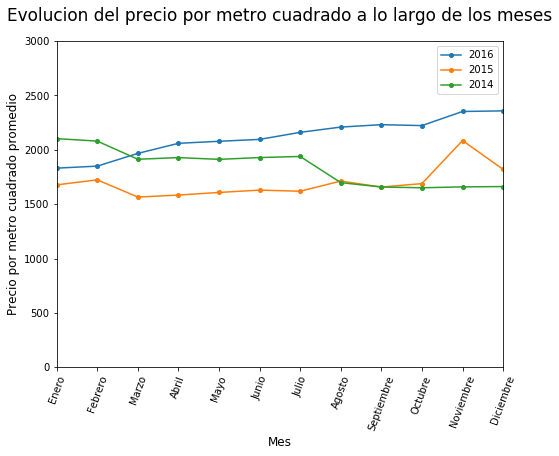

In [168]:
plot = precios.plot(rot = 70, marker = '.', markersize = 8);
plot.set_xlabel("Mes")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los meses")
plot.set_ylim([0,3000]);
plot.set_xticks(precios.index);
plot.set_xticklabels(meses);

### Que tipo de propiedad se vende mas?

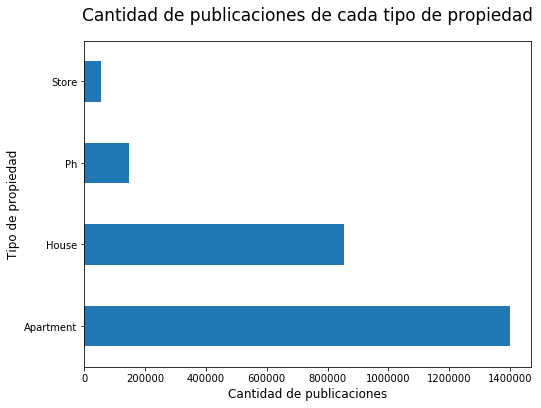

In [125]:
tipos_propiedades = propiedades.loc[:,'property_type'].str.capitalize().value_counts()
plot = tipos_propiedades.plot(kind='barh');
plot.set_title("Cantidad de publicaciones de cada tipo de propiedad")
plot.set_ylabel("Tipo de propiedad")
plot.set_xlabel("Cantidad de publicaciones")

In [73]:
precio_tipos_propiedades = propiedades.loc[(propiedades.price_aprox_usd <= 2000000) & (propiedades.price_aprox_usd >= 10000)\
                                           ,['property_type','price_aprox_usd','lat']]
precio_tipos_propiedades.loc[:,'property_type'] = precio_tipos_propiedades.loc[:,'property_type'].str.capitalize()

precio_tipos_propiedades = pd.pivot_table(precio_tipos_propiedades, values='price_aprox_usd', columns=['property_type'],index = 'lat')

(0, 650000)

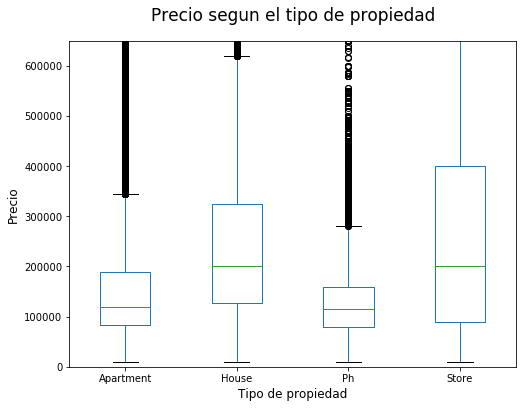

In [126]:
plot = precio_tipos_propiedades.plot.box()
plot.set_xlabel("Tipo de propiedad")
plot.set_ylabel("Precio")
plot.set_title("Precio segun el tipo de propiedad")
plot.set_ylim([0,650000])

### Cual es la relacion entre la superficie cubierta y la cantidad de habitaciones?

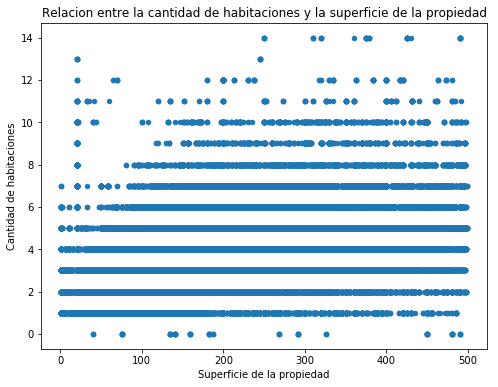

In [35]:
tiene_superficie = propiedades['superficie'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull()
habitaciones = propiedades.loc[tiene_superficie & tiene_habitaciones,:]
habitaciones = habitaciones.loc[(habitaciones['superficie'] < 500) & (habitaciones['rooms'] < 15 ),:]
plot = habitaciones.plot.scatter(x = 'superficie', y = 'rooms');
plot.set_xlabel("Superficie de la propiedad")
plot.set_ylabel("Cantidad de habitaciones")
plot.set_title("Relacion entre la cantidad de habitaciones y la superficie de la propiedad")

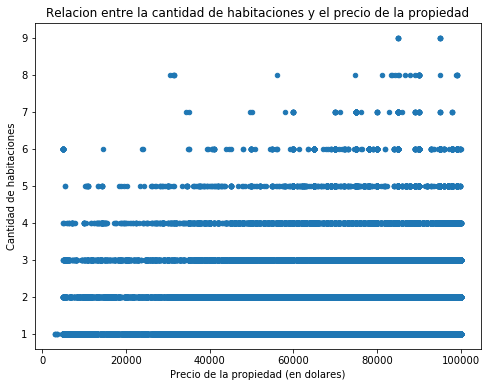

In [36]:
tiene_precio_usd = propiedades['price_aprox_usd'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull() & propiedades['rooms'] > 0
hab = propiedades.loc[tiene_precio_usd & tiene_habitaciones,:]
hab = hab.loc[(hab['price_aprox_usd'] > 1000) & (hab['price_aprox_usd'] < 100000) & (hab['rooms'] < 10),:]
plot = hab.plot.scatter(x = 'price_aprox_usd', y = 'rooms');
plot.set_xlabel("Precio de la propiedad (en dolares)")
plot.set_ylabel("Cantidad de habitaciones")
plot.set_title("Relacion entre la cantidad de habitaciones y el precio de la propiedad")

##### se ve que las propiedades mas baratas no tiene mas de 4-5 habitaciones y que solo las mas caras tiene mas de 6

### Relacion entre los distintos valores de dolar (Creo que no sirve para comparar)

In [37]:
valor_dolar = propiedades.loc[(propiedades['price_aprox_local_currency'].notnull()) & (propiedades['price_aprox_usd'].notnull()),['price_aprox_local_currency','price_aprox_usd','Year']]
valor_dolar ['dolar'] = valor_dolar['price_aprox_local_currency'] / valor_dolar['price_aprox_usd']
#valor_dolar = valor_dolar[valor_dolar ['dolar'] > 10]
valor_dolar.describe()

,price_aprox_local_currency,price_aprox_usd,Year,dolar
count,2.143095e+06,2.143095e+06,2.143095e+06,2.123129e+06
mean,2.624328e+06,2.301209e+05,2.015101e+03,1.101820e+01
std,4.536521e+06,3.535100e+05,1.249927e+00,3.883765e+00
min,0.000000e+00,0.000000e+00,2.013000e+03,5.347992e+00
25%,8.632503e+05,9.000000e+04,2.014000e+03,8.386000e+00
50%,1.503608e+06,1.430000e+05,2.015000e+03,9.198400e+00
75%,2.874330e+06,2.550000e+05,2.016000e+03,1.596850e+01
max,8.014550e+08,5.000000e+07,2.017000e+03,1.662200e+01


In [38]:
valor_dolar = valor_dolar.loc[:,['Year', 'dolar']].groupby('Year').agg(np.mean)
valor_dolar

,dolar
Year,
2013,5.808153
2014,8.081192
2015,9.401477
2016,15.968500
2017,16.128413


## Tomamos algunos barrios importantes y hacemos comparaciones

In [174]:
barrios = ['Palermo', 'Vicente López', 'Lomas de Zamora', 'La Matanza']  #Elegi uno de cada zona
df = []
for barrio in barrios:
    a = propiedades[tiene_precio].loc[propiedades.place_name == barrio,['Year','price_usd_per_m2']]\
    .groupby('Year').agg(np.mean).reset_index().rename(columns={'price_usd_per_m2' : barrio})
    df.append(a)

In [175]:
precios_barrios = df[0]
for x in range (1,len(barrios)):
    precios_barrios = pd.merge(precios_barrios,df[x],how='outer')
precios_barrios.set_index("Year",inplace = True)
precios_barrios

,Palermo,Vicente López,Lomas de Zamora,La Matanza
Year,,,,
2013,3045.593394,2773.353764,2468.826751,2821.583231
2014,2965.790436,2175.935660,1587.086071,1867.924150
2015,3139.452200,2140.177017,1592.004317,1625.846192
2016,3318.524747,2429.855370,1612.371211,1930.060818
2017,3601.772003,3346.559792,1997.987134,1888.998619


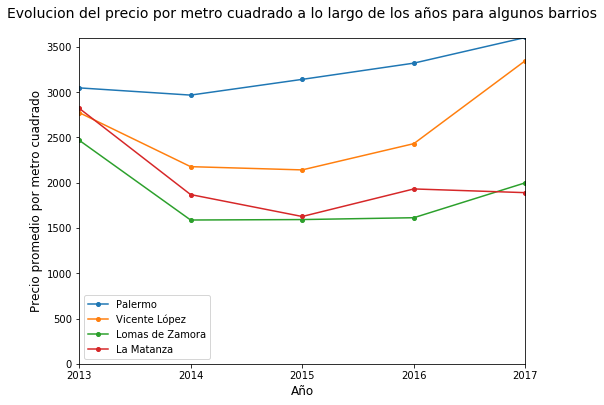

In [177]:
plot = precios_barrios.plot(marker = '.', markersize = 8);
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio por metro cuadrado")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años para algunos barrios",size = 14)
plot.set_ylim([0,3600]);
plot.set_xticks([2013,2014,2015,2016,2017]);

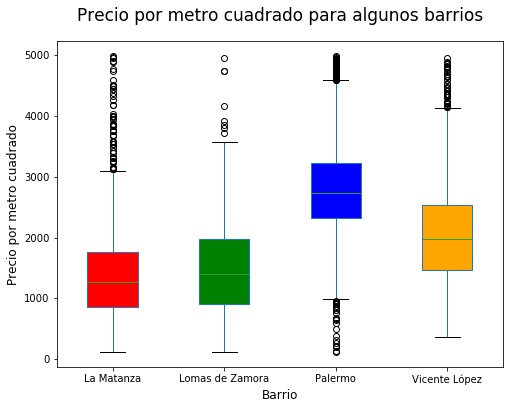

In [179]:
precios_barrios2 = propiedades.loc[(propiedades.price_usd_per_m2 < 5000) &\
                        (propiedades.price_usd_per_m2 > 100)&((propiedades.place_name == barrios[0]) | \
                          (propiedades.place_name == barrios[1]) | (propiedades.place_name == barrios[2])\
                        | (propiedades.place_name == barrios[3])),\
        ['lon','place_name','price_usd_per_m2']].pivot_table(index='lon',columns='place_name')
precios_barrios2.columns = precios_barrios2.columns.droplevel()
boxplot = precios_barrios2.plot.box(patch_artist=True,return_type='dict', title="Precio por metro cuadrado para algunos barrios");
ax=plt.gca()
ax.set_ylabel('Precio por metro cuadrado')
ax.set_xlabel('Barrio')


colors = ['red' , 'green', 'blue', 'orange'] #Mismos colores del grafico de lineas de arriba
    
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)


## Relacion entre precios y distancia a lugares importantes

In [201]:
solo_capital = pd.read_csv('solo_capital.csv')
#solo_capital = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/solo_capital.csv')

#Lo exporte a csv porque tardaba mucho los calculos de distancia

/home/mati/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
def calcular_distancia(lat1,long1,lat2,long2):
    lon1, lat1 = (radians(coord) for coord in (long1,lat1))
    lon2, lat2 = (radians(coord) for coord in (long2,lat2))
    dlat = (lat2 - lat1)
    dlon = (lon2 - lon1)
    a = (
        sin(dlat * 0.5)**2 +
        cos(lat1) * cos(lat2) * sin(dlon * 0.5)**2
    )
    
    radioTierra = 6371008.8
    return 2 * radioTierra * asin(sqrt(a)) / 1000

#distancia de Haversine
#https://gist.github.com/habibutsu/8bbcc202a915e965c6a6d4f561d0e482

In [11]:
def calcular_distancia_minima(fila, distancia_minima):

    lugares = ['Obelisco','Cabildo','Planetario','Jardin Botanico','Abasto','Museo del arte',\
              'Catedral metropolitana', 'Museo Histórico Nacional', 'Museo Evita', 'Alto Palermo',\
              'Dot']
    latitudes = [-34.603075,-34.608661,-34.569722,-34.582639,-34.603611,-34.57722222, -34.607408, -34.626944, -34.5806484, -34.588321, -34.545737]
    longitudes = [-58.381653,-58.373611,-58.411667,-58.417361,-58.410833,-58.40336111, -58.373278, -58.370556, -58.4146929, -58.410757, -58.488341]
    lat1,long1 = fila
    distancias = []
    
    for i in range(len(lugares)):
        distancia = calcular_distancia(lat1,long1,latitudes[i],longitudes[i])
        distancias.append(distancia)
        if (distancia <= distancia_minima):
            return distancia
    
    return min(distancias)

#Si agregamos lugares hay que calcularlo de vuelta

In [12]:
#solo_capital = propiedades.loc[(propiedades.state_name == 'Capital Federal') & (propiedades.lat.notnull()) & (propiedades.lon.notnull()),:]
#solo_capital = solo_capital.loc[((solo_capital.lat <= -34) & (solo_capital.lat >= -35)),:]
#solo_capital = solo_capital.loc[((solo_capital.lon <= -58) & (solo_capital.lon >= -59)),:]
#solo_capital.loc[:,'distancia_monumentos'] = solo_capital.loc[:,['lat','lon']].apply(lambda x: calcular_distancia_minima(x,0.5), axis = 1)
solo_capital.head(2)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,distancia_subtes,distancia_monumentos
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,apartment,3.0,Capital Federal,102.0,2013,7,0.649099,2.778648
1,NaN,2012-08-08,USD,NaN,2013-07-01,10.0,-34.597915,-58.417149,Palermo,|Argentina|Capital Federal|Palermo|,...,NaN,2716.40625,apartment,1.0,Capital Federal,32.0,2013,7,0.680153,0.857521


In [13]:
solo_capital['distancia_monumentos'].describe()

count    854010.000000
mean          3.408286
std           4.748301
min           0.023206
25%           1.134176
50%           2.384136
75%           3.817520
max          73.781522
Name: distancia_monumentos, dtype: float64

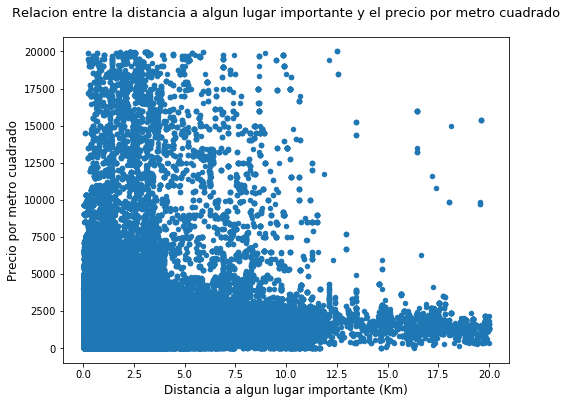

In [203]:
dist = solo_capital.loc[(solo_capital.price_usd_per_m2.notnull()) & (solo_capital.price_usd_per_m2 < 20000) & (solo_capital.distancia_monumentos < 20),:]
plot = dist.plot.scatter(x = 'distancia_monumentos', y = 'price_usd_per_m2');
plot.set_xlabel("Distancia a algun lugar importante (Km)")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Relacion entre la distancia a algun lugar importante y el precio por metro cuadrado",size = 13);

## Relacion entre el precio y cercania a los subtes

In [51]:
# Datos obtenidos en https://data.buenosaires.gob.ar/
subtes = pd.read_csv('estaciones-de-subte.csv', sep = ",")
subtes.tail()

,X,Y,ID,ESTACION,LINEA
81,-58.469640,-34.630707,83.0,SAN PEDRITO,A
82,-58.463541,-34.629087,82.0,SAN JOSE DE FLORES,A
83,-58.403721,-34.598455,84.0,CORDOBA,H
84,-58.397216,-34.587462,85.0,LAS HERAS,H
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H


In [52]:
subtes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
X           86 non-null float64
Y           86 non-null float64
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
dtypes: float64(3), object(2)
memory usage: 3.4+ KB


In [53]:
def distancia_subtes(fila, d_max):
    lat, lon = fila
    distancias = []
    for i in range (len(subtes)):
        d = calcular_distancia(lat,lon,subtes.Y[i], subtes.X[i])
        if d <= d_max:
            return d
        distancias.append(d)
    return min(distancias)

In [54]:
#Tardo media hora   lo exporte a csv


#solo_capital.loc[:,'distancia_subtes'] = solo_capital.loc[:,['lat','lon']].apply(lambda x: distancia_subtes(x,0.5), axis = 1)
solo_capital.head(2)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,distancia_subtes,distancia_monumentos
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,apartment,3.0,Capital Federal,102.0,2013,7,0.649099,4.930767
1,NaN,2012-08-08,USD,NaN,2013-07-01,10.0,-34.597915,-58.417149,Palermo,|Argentina|Capital Federal|Palermo|,...,NaN,2716.40625,apartment,1.0,Capital Federal,32.0,2013,7,0.680153,0.857521


In [55]:
solo_capital['distancia_subtes'].describe()

count    854797.000000
mean          1.616011
std           5.883526
min           0.000356
25%           0.386925
50%           0.629416
75%           1.159004
max         444.444997
Name: distancia_subtes, dtype: float64

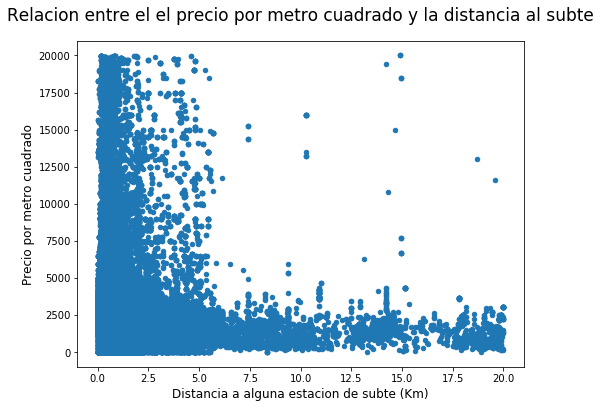

In [204]:
dist = solo_capital.loc[(solo_capital.price_usd_per_m2.notnull()) & (solo_capital.price_usd_per_m2 < 20000) & (solo_capital.distancia_subtes < 20),:]
plot = dist.plot.scatter(x = 'distancia_subtes', y = 'price_usd_per_m2');
plot.set_xlabel("Distancia a alguna estacion de subte (Km)")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Relacion entre el el precio por metro cuadrado y la distancia al subte")

## Relacion entre el precio y el piso del depto

In [189]:
piso_maximo = 20  

departamentos = propiedades.loc[(propiedades.property_type == 'apartment') & (propiedades.floor.notnull())\
                               & (propiedades.floor <= piso_maximo)]
departamentos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388377 entries, 0 to 2455239
Data columns (total 23 columns):
created_on                    388377 non-null object
currency                      355983 non-null object
expenses                      36083 non-null float64
fecha_de_publicacion          388377 non-null object
floor                         388377 non-null float64
lat                           293036 non-null float64
lon                           293036 non-null float64
place_name                    388377 non-null object
place_with_parent_names       388377 non-null object
price                         357355 non-null float64
price_aprox_local_currency    357355 non-null float64
price_aprox_usd               357355 non-null float64
price_per_m2                  102967 non-null float64
price_usd_per_m2              297383 non-null float64
property_type                 388377 non-null object
rooms                         266207 non-null float64
state_name                    3

In [190]:
departamentos['floor'].describe()

count    388377.000000
mean          4.504072
std           3.615925
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          20.000000
Name: floor, dtype: float64

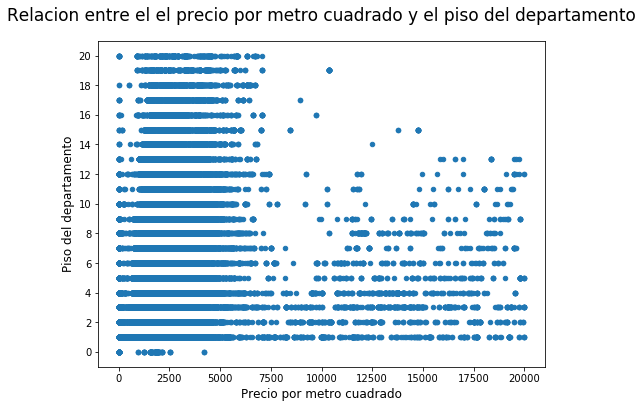

In [200]:
plot = departamentos.loc[(departamentos.price_usd_per_m2.notnull()) & (departamentos.price_usd_per_m2 <= 20000), :].plot\
            .scatter(y = 'floor', x = 'price_usd_per_m2');
plot.set_ylabel("Piso del departamento");
plot.set_xlabel("Precio por metro cuadrado");
plot.set_title("Relacion entre el el precio por metro cuadrado y el piso del departamento");
plot.set_yticks(list(range(0,21,2)));

#### cuanto mas alto, mas barato el precio por m2

# relacion entre expensas y precio total

In [60]:
def convertir_expensas(fila):
    """Convierto las expensas a float, y si no se puede devuelve nan"""
    try:
        return float(fila)
    except:
        return np.nan
    
#Ya no es necesario

In [61]:
#propiedades.loc[:,'expenses'] = propiedades.loc[:,'expenses'].apply(convertir_expensas)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 23 columns):
created_on                    object
currency                      object
expenses                      float64
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
superficie                    float64
Year                          int64
Month                         int64
Year_created                  int64
Month_created                 int64
cantidad_meses_publicado      int64
dtypes: float64(11), int64(5),

In [205]:
expensas = propiedades.loc[(propiedades.expenses.notnull()) & (propiedades.expenses <= 10000) & (propiedades.expenses > 100),:]
expensas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120606 entries, 56 to 2455308
Data columns (total 23 columns):
created_on                    120606 non-null object
currency                      114941 non-null object
expenses                      120606 non-null float64
fecha_de_publicacion          120606 non-null object
floor                         36153 non-null float64
lat                           107699 non-null float64
lon                           107699 non-null float64
place_name                    120592 non-null object
place_with_parent_names       120606 non-null object
price                         115679 non-null float64
price_aprox_local_currency    115679 non-null float64
price_aprox_usd               115679 non-null float64
price_per_m2                  81814 non-null float64
price_usd_per_m2              105668 non-null float64
property_type                 120606 non-null object
rooms                         93885 non-null float64
state_name                    12

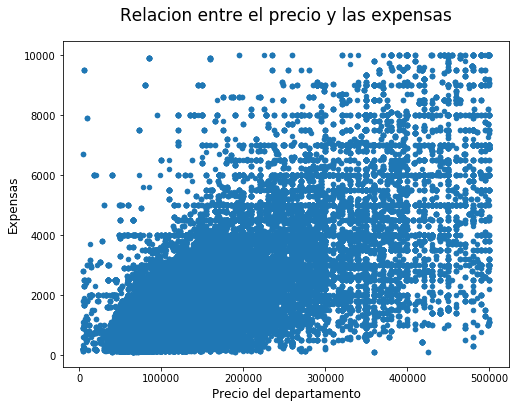

In [206]:
expensas_y_precio = expensas.loc[(expensas.price_aprox_usd.notnull()) & (expensas.price_aprox_usd <= 500000) & (expensas.price_aprox_usd > 100),:]
plot = expensas_y_precio.plot.scatter(y = 'expenses', x = 'price_aprox_usd');
plot.set_ylabel("Expensas")
plot.set_xlabel("Precio del departamento")
plot.set_title("Relacion entre el precio y las expensas")

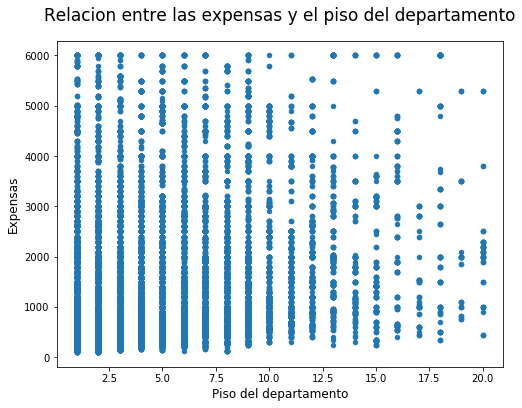

In [207]:
expensas_y_piso = expensas.loc[(expensas.floor.notnull()) & (expensas.floor <= piso_maximo) & (expensas.expenses <= 6000),:]
plot = expensas_y_piso.plot.scatter(y = 'expenses', x = 'floor');
plot.set_ylabel("Expensas")
plot.set_xlabel("Piso del departamento")
plot.set_title("Relacion entre las expensas y el piso del departamento")

#### cuanto mas caro mas expensas paga

# Analizando fecha de creacion y fecha de publicacion

In [65]:
#Ya no es necesario

#propiedades.loc[:,'Year_created'] = propiedades.loc[:,'created_on'].apply(obtener_anio)
#propiedades.loc[:,'Month_created'] = propiedades.loc[:,'created_on'].apply(obtener_mes)
propiedades.head()

,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado
0,2012-08-08,NaN,NaN,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,...,NaN,apartment,3.0,Capital Federal,102.0,2013,7,2012,8,11
1,2012-08-08,NaN,NaN,2013-07-01,11.0,-34.546730,-58.550579,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,...,NaN,apartment,3.0,Bs.As. G.B.A. Zona Norte,73.0,2013,7,2012,8,11
2,2012-08-08,NaN,NaN,2013-07-01,NaN,-34.543776,-58.559615,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,...,NaN,house,4.0,Bs.As. G.B.A. Zona Norte,485.0,2013,7,2012,8,11
3,2012-08-08,USD,NaN,2013-07-01,NaN,-34.558247,-58.564806,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,110000.0,...,315.186246,house,4.0,Bs.As. G.B.A. Zona Norte,349.0,2013,7,2012,8,11
4,2012-08-08,NaN,NaN,2013-07-01,NaN,-34.568371,-58.598724,Loma Hermosa,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,NaN,...,NaN,apartment,3.0,Bs.As. G.B.A. Zona Oeste,NaN,2013,7,2012,8,11


In [66]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 23 columns):
created_on                    object
currency                      object
expenses                      float64
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
superficie                    float64
Year                          int64
Month                         int64
Year_created                  int64
Month_created                 int64
cantidad_meses_publicado      int64
dtypes: float64(11), int64(5),

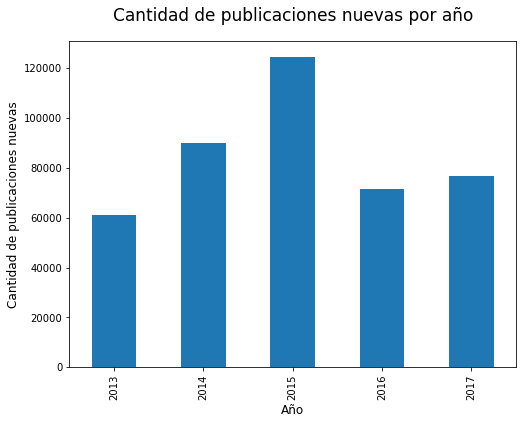

In [208]:
publicaciones = propiedades.loc[(propiedades.Year == propiedades.Year_created) & (propiedades.Month == propiedades.Month_created),['Month','Year']]
plot = publicaciones.groupby('Year').agg([np.size,np.mean])[('Month', 'size')].plot(kind = 'bar');
plot.set_ylabel("Cantidad de publicaciones nuevas")
plot.set_xlabel("Año")
plot.set_title("Cantidad de publicaciones nuevas por año")

#### Tener en cuenta que 2017 no termino, y ya tiene mas que 2016 y 2013

In [68]:
def distancia_entre_fechas(fila):
    year, year_created, month, month_created = fila
    return (month - month_created) + 12 * (year - year_created)
    

In [69]:
#Ya no es encesario

#propiedades.loc[:, 'cantidad_meses_publicado'] = propiedades.loc[:,['Year', 'Year_created', 'Month', 'Month_created']].apply(distancia_entre_fechas, axis = 1)

In [209]:
publicados = propiedades.loc[:,['lat','lon','cantidad_meses_publicado', 'Year','Month']].groupby(['lat','lon']).max()
publicados.head()

,,cantidad_meses_publicado,Year,Month
lat,lon,,,
-89.999744,135.000000,2,2015,11
-87.953559,164.531250,3,2015,11
-76.516815,100.000000,4,2014,11
-58.804368,58.804368,3,2014,12
-58.430839,-34.571160,3,2014,12


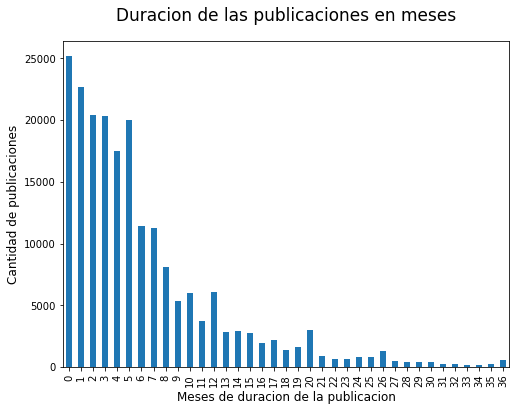

In [210]:
publicados = publicados.loc[(publicados.cantidad_meses_publicado >= 0) & (publicados.cantidad_meses_publicado <= 36),:]
plot = publicados.groupby('cantidad_meses_publicado').agg([np.size,np.mean])\
            [('Year','size')].plot(kind = 'bar');
plot.set_ylabel("Cantidad de publicaciones")
plot.set_xlabel("Meses de duracion de la publicacion")
plot.set_title("Duracion de las publicaciones en meses")

In [71]:
propiedades.head()

,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,...,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,Year_created,Month_created,cantidad_meses_publicado
0,2012-08-08,NaN,NaN,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,...,NaN,apartment,3.0,Capital Federal,102.0,2013,7,2012,8,11
1,2012-08-08,NaN,NaN,2013-07-01,11.0,-34.546730,-58.550579,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,...,NaN,apartment,3.0,Bs.As. G.B.A. Zona Norte,73.0,2013,7,2012,8,11
2,2012-08-08,NaN,NaN,2013-07-01,NaN,-34.543776,-58.559615,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,...,NaN,house,4.0,Bs.As. G.B.A. Zona Norte,485.0,2013,7,2012,8,11
3,2012-08-08,USD,NaN,2013-07-01,NaN,-34.558247,-58.564806,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,110000.0,...,315.186246,house,4.0,Bs.As. G.B.A. Zona Norte,349.0,2013,7,2012,8,11
4,2012-08-08,NaN,NaN,2013-07-01,NaN,-34.568371,-58.598724,Loma Hermosa,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,NaN,...,NaN,apartment,3.0,Bs.As. G.B.A. Zona Oeste,NaN,2013,7,2012,8,11


In [72]:
# link con algunos colores para los graficos
# https://matplotlib.org/users/colors.html

In [14]:
#propiedades.to_csv('properati.csv', index = False)
#solo_capital.to_csv('solo_capital.csv', index = False)

#para exportar a csv y que no aparezca la columna Unnamed 0